# Momentum Decile Performance

The [Fama-French](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_10_port_form_pr_12_2_daily.html) data-set has returns for portfolios constructed out of each decile of prior returns. Labeled LO_PRIOR, PRIOR_2..9 and HI_PRIOR, they represent portfolios who's prior returns were the lowest through to the highest.

Here, we plot the returns of these portfolios to get a sense for how they have behaved through time.

The documentation for the Fama-French data-set can be found [here](https://plutopy.readthedocs.io/en/latest/FamaFrench.html) and [here](https://shyams80.github.io/plutoR/docs/reference/FamaFrench-class.html)

In [1]:
library(tidyverse)
library(ggthemes)
library(odbc)
library(plutoR)
library(quantmod)
library(lubridate)
library(reshape2)
library(PerformanceAnalytics)
library(ggrepel)
library(tbl2xts)

options("scipen"=999)
options(stringsAsFactors = FALSE)
options(repr.plot.width=16, repr.plot.height=8)

source("config.R")
source("goofy/plot.common.R")

#initialize
famaFrench <- FamaFrench()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: TTR
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Version 0.4-0 included new data defaults. See ?getSymbols.

Attaching package: ‘lubridate’

The following object is masked from ‘package:b

In [2]:
calcYearlyReturns <- function(priceXts){
    yRets <- NULL
    for(j in 1:ncol(priceXts)){
        yRets <- merge.xts(yRets, yearlyReturn(priceXts[,j]))
    }
    
    names(yRets) <- names(priceXts)
    return(yRets)
}

In [3]:
#startDt <- (famaFrench$MomentumDaily() %>% summarize(MAX = min(TIME_STAMP)) %>% collect())$MAX[[1]]
startDt <- as.Date("2015-01-01")

valueWtd <- famaFrench$MomentumDaily() %>%
    filter(RET_TYPE == 'AVWRD' & TIME_STAMP >= startDt) %>%
    mutate(R = RET/100) %>%
    select(DATE = TIME_STAMP, KEY_ID, R) %>%
    collect() %>% 
    # the KEY_ID column has decile names HI_PRIOR...LO_PRIOR
    # we want HI_PRIOR...LO_PRIOR as column names
    mutate(group=1) %>%
    spread(KEY_ID, R) %>%
    select(-group)
    
valueWtdPx <- valueWtd %>% 
    # transform the return stream to prices
    # and convert to xts
    mutate_each(list(~ cumprod(. + 1) ), -DATE) %>% 
    tbl_xts() 

valueWtdYearlyRet <- 100*calcYearlyReturns(valueWtdPx)
valueWtdDailyRet <- valueWtd %>% 
    tbl_xts()

In [4]:
plotAnnualReturns <- function(yearlies, mainTitle){
    yDf <- data.frame(yearlies)
    yDf$T <- year(index(yearlies))

    toPlot <- melt(yDf, id='T')

    ggplot(toPlot, aes(x=T, y=value, fill=variable)) +
        theme_economist() +
        geom_bar(stat="identity", position=position_dodge()) +
        scale_x_continuous(labels=yDf$T, breaks=yDf$T) +
        geom_text_repel(aes(label= round(value, 2)), position = position_dodge(0.9)) +
        coord_flip() +
        labs(x='', y='(%)', fill='', title=mainTitle, subtitle="Annual Returns") +
        annotate("text", x=max(yDf$T), y=min(toPlot$value), 
                 label = "@StockViz", hjust=-0.5, vjust=0, 
                 col="white", cex=6, fontface = "bold", alpha = 0.8)  
}

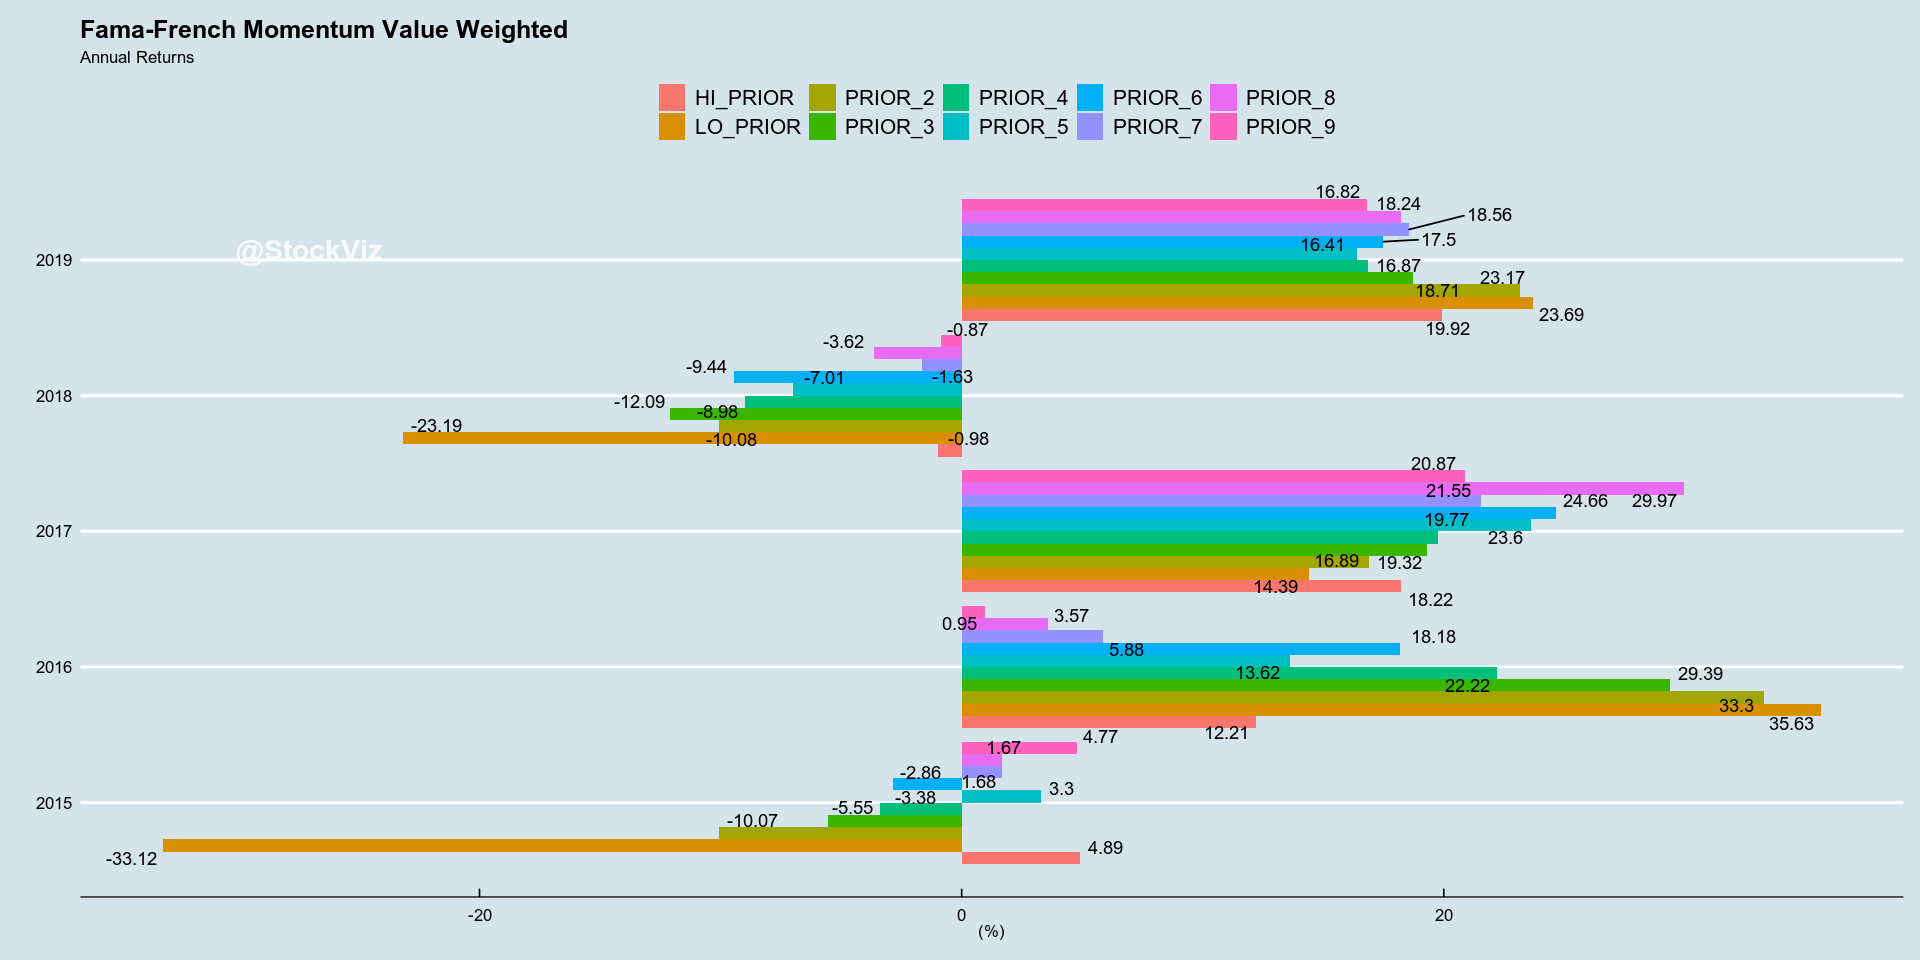

In [5]:
plotAnnualReturns(valueWtdYearlyRet, "Fama-French Momentum Value Weighted")

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)